# Logistic Regression on MNIST Database using Pytorch

In [1]:
import torch 
import torchvision
from torchvision.datasets import MNIST

## Working with Image

We'll use the famous [*MNIST Handwritten Digits Database*](http://yann.lecun.com/exdb/mnist/) as our training dataset. It consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. Here are some sample images from the dataset:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

## Data Preprocessing

In [2]:
# download dataset - pytorch will automatically converted them to a Pytorch Dataset object

dataset = MNIST(root='data/', download=True)

In [3]:
len(dataset)

60000

In [4]:
# creating test_dataset using train=False

test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [5]:
# sample element

dataset[0]   # it gives :- image(part of pillow), 5 (label digit)

(<PIL.Image.Image image mode=L size=28x28 at 0x25EA9AE4748>, 5)

In [7]:
import matplotlib.pyplot as plt  #indicates to jupyter we want to plot graphs within the notebook, without this it will show in popup
%matplotlib inline                

Label: 5


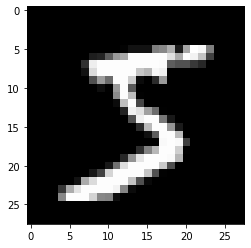

In [8]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 3


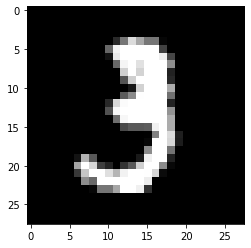

In [9]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

Pytorch dosen't know how to work with images, we need to convert images to tensors by specifying transform while creating our dataset

In [10]:
import torchvision.transforms as transform

In [11]:
# dataset of tensors

dataset = MNIST(root='data/',
                train=True,
               transform=transform.ToTensor())

In [12]:
img_tensor, label = dataset[0]
print(img_tensor.shape,label)

torch.Size([1, 28, 28]) 5


In [13]:
img_tensor

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [14]:
# some sample values insode the tensor

print(img_tensor[:,10:15,10:15])
print(torch.max(img_tensor),torch.min(img_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


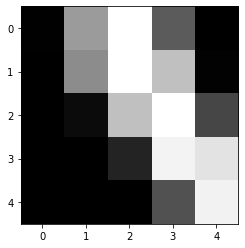

In [15]:
# plot image by passing 28x28 matrix

plt.imshow(img_tensor[0,10:15,10:15], cmap='gray')

## Training and Validation Datasets

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images. 

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the `random_spilt` method from PyTorch.

In [16]:
# manually split training set to 50000-10000 validation set

# using random_split

from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [17]:
# Creating Data_loaders to helpus load data in batches - size=128

from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True) # shuffle=True for the training data loader to ensure batches generated in each epoch are different  # randomization helps generalize and speed=up the training process
val_loader = DataLoader(val_ds, batch_size )

## Model

* A **logistic regression** model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`). 

* As we did with linear regression, we can use `nn.Linear` to create the model instead of manually creating and initializing the matrices.

* Since `nn.Linear` expects each training example to be a vector, each `1x28x28` image tensor is _flattened_ into a vector of size 784 `(28*28)` before being passed into the model. 

* The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [18]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

#Logistic regression model

model = nn.Linear(input_size, num_classes)

In [19]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[ 0.0097, -0.0244, -0.0155,  ..., -0.0295,  0.0300, -0.0210],
        [ 0.0036,  0.0262, -0.0189,  ...,  0.0118,  0.0162, -0.0324],
        [ 0.0041, -0.0117, -0.0011,  ...,  0.0128,  0.0156, -0.0292],
        ...,
        [-0.0163, -0.0195, -0.0283,  ..., -0.0236,  0.0138,  0.0091],
        [ 0.0336, -0.0344,  0.0232,  ..., -0.0277, -0.0007, -0.0115],
        [ 0.0130,  0.0136,  0.0206,  ...,  0.0128, -0.0171, -0.0017]],
       requires_grad=True)

In [20]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([ 0.0144, -0.0100,  0.0354, -0.0225, -0.0262,  0.0286,  0.0230, -0.0162,
        -0.0203,  0.0171], requires_grad=True)

so total parameters = 7850 

In [21]:
# taking 1st batch of 100 images from our bataset and pass them into our model

for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([7, 2, 1, 5, 4, 8, 6, 0, 0, 5, 3, 7, 9, 0, 8, 4, 5, 2, 5, 9, 3, 0, 6, 6,
        4, 9, 2, 1, 5, 9, 3, 3, 4, 1, 0, 4, 2, 0, 0, 5, 6, 8, 9, 7, 6, 0, 4, 1,
        2, 1, 9, 2, 6, 8, 5, 2, 8, 7, 7, 9, 7, 6, 7, 5, 9, 5, 5, 9, 1, 7, 5, 0,
        7, 7, 2, 5, 0, 8, 1, 1, 7, 8, 7, 4, 7, 3, 1, 6, 4, 9, 9, 3, 9, 3, 5, 6,
        6, 5, 6, 4, 2, 4, 5, 1, 8, 7, 0, 3, 9, 9, 5, 2, 7, 6, 9, 8, 5, 1, 3, 2,
        3, 6, 4, 1, 3, 9, 7, 3])
torch.Size([128, 1, 28, 28])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x28 and 784x10)

error occurred bcoz, input data dosen't have right shape. images are of the shape 1x28x28, but we need them to be vectors of size 784 ie we need to flatten them --> using .reshape 

In [22]:
images.shape

torch.Size([128, 1, 28, 28])

In [23]:
images.reshape(128,784).shape

torch.Size([128, 784])

To include this additional function within out model, we need to define a custom model by extending the nn.Module class

Inside the `__init__` constructor method, we instantiate the weights and biases using `nn.Linear`. And inside the `forward` method, which is invoked when we pass a batch of inputs to the model, we flatten the input tensor and pass it into `self.linear`.

`xb.reshape(-1, 28*28)` indicates to PyTorch that we want a *view* of the `xb` tensor with two dimensions. The length along the 2nd dimension is 28\*28 (i.e., 784). One argument to `.reshape` can be set to `-1` (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has `.weight` and `.bias` attributes (as they are now inside the `.linear` attribute), but it does have a `.parameters` method that returns a list containing the weights and bias.

In [24]:
# extending nn.Module class

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    
model = MnistModel() #object

In [25]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [26]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters()) # bundle all weights and biases

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 3.4617e-02,  2.8410e-02,  2.5686e-02,  ..., -1.5863e-02,
          -3.8656e-03,  1.5305e-02],
         [-1.8018e-02,  1.7917e-02, -3.0232e-02,  ..., -5.3763e-03,
          -3.2701e-02,  1.7136e-02],
         [-3.4262e-02,  8.5667e-03, -2.0011e-02,  ..., -1.8257e-02,
           3.4308e-02,  1.8136e-02],
         ...,
         [ 9.5943e-03,  1.6986e-02,  2.2343e-02,  ...,  4.5605e-03,
           9.5017e-03, -2.5854e-04],
         [-1.4468e-02, -2.7529e-02,  2.9830e-02,  ..., -9.3204e-03,
           6.1549e-03, -2.5384e-02],
         [ 3.3574e-02,  2.1621e-03, -8.8337e-03,  ..., -4.9651e-05,
          -2.1324e-02,  2.4071e-03]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0054, -0.0311,  0.0240,  0.0014, -0.0334,  0.0090, -0.0151, -0.0068,
          0.0042, -0.0279], requires_grad=True)]

In [27]:
# we can use custom model in same as before 

for images, labels in train_loader:
    outputs = model(images)
    break
    
print('output.shape :', outputs.shape)
print('Sample outputs layer 0 :', outputs[0].data)
print('Sample outputs layer 0 and 1 :', outputs[:2].data)

output.shape : torch.Size([128, 10])
Sample outputs layer 0 : tensor([-0.1530, -0.4023,  0.0156, -0.0506,  0.0551, -0.2542,  0.0123, -0.3361,
        -0.1795,  0.1995])
Sample outputs layer 0 and 1 : tensor([[-0.1530, -0.4023,  0.0156, -0.0506,  0.0551, -0.2542,  0.0123, -0.3361,
         -0.1795,  0.1995],
        [-0.2933, -0.3964,  0.2764, -0.0050, -0.0035, -0.0671,  0.2888, -0.2759,
         -0.1555,  0.0238]])


For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities. Each output row's elements must lie between 0 to 1 and add up to 1, which is not the case. 

To convert the output rows into probabilities, we use the softmax function, which has the following formula:

![softmax](https://i.imgur.com/EAh9jLN.png)

First, we replace each element `yi` in an output row by `e^yi`, making all the elements positive. 

![](https://www.montereyinstitute.org/courses/DevelopmentalMath/COURSE_TEXT2_RESOURCE/U18_L1_T1_text_final_6_files/image001.png)



Then, we divide them by their sum to ensure that they add up to 1. The resulting vector can thus be interpreted as probabilities.

we'll use the implementation that's provided within PyTorch because it works well with multidimensional tensors (a list of output rows in our case).

In [28]:
import torch.nn.functional as F

In [29]:
outputs[0:2]

tensor([[-0.1530, -0.4023,  0.0156, -0.0506,  0.0551, -0.2542,  0.0123, -0.3361,
         -0.1795,  0.1995],
        [-0.2933, -0.3964,  0.2764, -0.0050, -0.0035, -0.0671,  0.2888, -0.2759,
         -0.1555,  0.0238]], grad_fn=<SliceBackward>)

In [30]:
probs = F.softmax(outputs, dim=1) # apply softmax for each output row # see why dim=0 dosen't workout

print("sample probabilities:\n", probs[:2].data) #sample probs

print("Sum: ", torch.sum(probs[0]).item()) # addup probs of an output row

sample probabilities:
 tensor([[0.0942, 0.0734, 0.1115, 0.1044, 0.1160, 0.0851, 0.1111, 0.0784, 0.0917,
         0.1340],
        [0.0774, 0.0698, 0.1368, 0.1032, 0.1034, 0.0970, 0.1385, 0.0787, 0.0888,
         0.1063]])
Sum:  1.0


In [31]:
# predicted label for each index is index of element with max probab

max_probs, preds = torch.max(probs, dim=1)

print(preds)
print(max_probs)

tensor([9, 6, 2, 9, 2, 2, 9, 5, 3, 9, 3, 8, 6, 9, 2, 9, 9, 8, 9, 9, 9, 3, 6, 3,
        6, 3, 5, 3, 2, 2, 3, 9, 9, 8, 2, 2, 9, 6, 6, 4, 2, 0, 9, 9, 2, 2, 9, 9,
        2, 9, 9, 9, 9, 9, 9, 9, 6, 9, 3, 3, 6, 9, 9, 3, 2, 3, 9, 8, 4, 8, 8, 4,
        9, 2, 5, 2, 9, 2, 8, 2, 2, 6, 3, 4, 9, 9, 9, 9, 6, 6, 9, 6, 9, 3, 9, 9,
        0, 6, 3, 2, 3, 5, 5, 3, 8, 3, 8, 2, 4, 3, 0, 9, 9, 6, 6, 3, 5, 2, 3, 9,
        3, 2, 7, 9, 9, 2, 9, 9])
tensor([0.1340, 0.1385, 0.1331, 0.1312, 0.1378, 0.1389, 0.1765, 0.1426, 0.1205,
        0.1485, 0.1351, 0.1217, 0.1359, 0.1315, 0.1463, 0.1313, 0.1251, 0.1250,
        0.1213, 0.1374, 0.1270, 0.1285, 0.1210, 0.1202, 0.1537, 0.1311, 0.1201,
        0.1155, 0.1454, 0.1945, 0.1293, 0.1238, 0.1146, 0.1202, 0.1568, 0.1285,
        0.1396, 0.1146, 0.1350, 0.1179, 0.1579, 0.1335, 0.1622, 0.1176, 0.1568,
        0.1461, 0.1368, 0.1345, 0.1403, 0.1409, 0.1426, 0.1331, 0.1502, 0.1324,
        0.1265, 0.1440, 0.1352, 0.1367, 0.1186, 0.1284, 0.1301, 0.1446, 0.1604,
       

In [32]:
# we have not trained yet

labels

tensor([9, 8, 5, 3, 3, 3, 2, 1, 0, 7, 2, 5, 3, 4, 8, 7, 4, 1, 9, 4, 9, 4, 4, 7,
        0, 9, 1, 7, 0, 0, 8, 5, 1, 8, 0, 4, 7, 8, 2, 5, 2, 1, 4, 6, 0, 8, 6, 9,
        5, 4, 9, 4, 9, 3, 4, 6, 3, 8, 1, 2, 2, 4, 9, 9, 5, 6, 9, 1, 8, 5, 8, 2,
        9, 0, 3, 0, 9, 7, 1, 1, 7, 8, 9, 7, 9, 4, 4, 6, 6, 3, 7, 5, 9, 8, 1, 9,
        9, 0, 2, 0, 0, 5, 1, 3, 9, 8, 1, 6, 9, 4, 6, 2, 5, 6, 8, 2, 1, 0, 2, 5,
        7, 6, 7, 7, 0, 1, 4, 6])

## Evaluation Metric and Loss Function

In [33]:
outputs[:2]

tensor([[-0.1530, -0.4023,  0.0156, -0.0506,  0.0551, -0.2542,  0.0123, -0.3361,
         -0.1795,  0.1995],
        [-0.2933, -0.3964,  0.2764, -0.0050, -0.0035, -0.0671,  0.2888, -0.2759,
         -0.1555,  0.0238]], grad_fn=<SliceBackward>)

In [34]:
preds == labels

tensor([ True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True, False,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
         True, False, False, False, False, False, False,  True, False, False,
         True, False,  True, False, False, False, False, False, False, False,
        False, False,  True, False, False, False,  True, False, False, False,
         True, False,  True, False, False, False,  True, False, False, False,
        False, False, False, False,  True, False, False, False,  True, False,
        False, False,  True, False, False,  True, False, False, False, False,
        False,  True, False,  True, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False])

In [35]:
torch.sum(preds == labels) # this is telling how many out of 128 were get predicted correctly

tensor(21)

## Accuracy of predictions




In [36]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [37]:
accuracy(outputs,labels)

tensor(0.1641)

The `==` operator performs an element-wise comparison of two tensors with the same shape and returns a tensor of the same shape, containing `True` for unequal elements and `False` for equal elements. Passing the result to `torch.sum` returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy. 

Note that we don't need to apply softmax to the outputs since its results have the same relative order. This is because `e^x` is an increasing function, i.e., if `y1 > y2`, then `e^y1 > e^y2`. The same holds after averaging out the values to get the softmax.

Let's calculate the accuracy of the current model on the first batch of data. 

 Accuracy is an excellent way for us (humans) to evaluate the model. However, we can't use it as a loss function for optimizing our model using gradient descent for the following reasons:

1. It's not a differentiable function. `torch.max` and `==` are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements. 

For these reasons, accuracy is often used as an **evaluation metric** for classification, but not as a loss function. A commonly used loss function for classification problems is the **cross-entropy**, which has the following formula:

![cross-entropy](https://i.imgur.com/VDRDl1D.png)

While it looks complicated, it's actually quite simple:

* For each output row, pick the predicted probability for the correct label. E.g., if the predicted probabilities for an image are `[0.1, 0.3, 0.2, ...]` and the correct label is `1`, we pick the corresponding element `0.3` and ignore the rest.

* Then, take the [logarithm](https://en.wikipedia.org/wiki/Logarithm) of the picked probability. If the probability is high, i.e., close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

![](https://www.intmath.com/blog/wp-content/images/2019/05/log10.png)

* Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function. It also provides useful feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). These two factors make cross-entropy a better choice for the loss function.

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the `torch.nn.functional` package. Moreover, it also performs softmax internally, so we can directly pass in the model's outputs without converting them into probabilities.

In [38]:
probs

tensor([[0.0942, 0.0734, 0.1115,  ..., 0.0784, 0.0917, 0.1340],
        [0.0774, 0.0698, 0.1368,  ..., 0.0787, 0.0888, 0.1063],
        [0.1088, 0.0800, 0.1331,  ..., 0.0638, 0.0798, 0.1175],
        ...,
        [0.1022, 0.0864, 0.1257,  ..., 0.0881, 0.1148, 0.1158],
        [0.0974, 0.0822, 0.0975,  ..., 0.0675, 0.0971, 0.1339],
        [0.0905, 0.1213, 0.1075,  ..., 0.0760, 0.1040, 0.1229]],
       grad_fn=<SoftmaxBackward>)

In [39]:
loss_fn = F.cross_entropy

In [40]:
# loss for current batch of data

loss = loss_fn(outputs, labels)

In [41]:
print(loss)

tensor(2.3150, grad_fn=<NllLossBackward>)


# Training the model

In [73]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for reading epoch-wise results
    
    for epoch in range(epochs):
        
        #training phase
        
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step() # change the gradients using the learning rate
            optimizer.zero_grad()
            
            
        #validation phase
        
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history

In [74]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader] #list comprehension 
    return model.validation_epoch_end(outputs)

Gaps to fill-in are : training_step, validation_step, validation_epoch_end, epoch_end used by : fit, evaluate

In [78]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                         # Generate predictions
        loss = F.cross_entropy(out, labels)        # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                          # Generate predictions
        loss = F.cross_entropy(out, labels)         #loss
        acc = accuracy(out, labels)                 # clac accuracy
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss  = torch.stack(batch_losses).mean()  #combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_accs = torch.stack(batch_accs).mean()     #combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_accs.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        
        
model = MnistModel()

In [79]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.283280611038208, 'val_acc': 0.10749604552984238}

## Train the model

In [80]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9208, val_acc: 0.6665
Epoch [1], val_loss: 1.6565, val_acc: 0.7396
Epoch [2], val_loss: 1.4599, val_acc: 0.7663
Epoch [3], val_loss: 1.3116, val_acc: 0.7836
Epoch [4], val_loss: 1.1978, val_acc: 0.7975


In [81]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1083, val_acc: 0.8057
Epoch [1], val_loss: 1.0365, val_acc: 0.8137
Epoch [2], val_loss: 0.9777, val_acc: 0.8194
Epoch [3], val_loss: 0.9287, val_acc: 0.8240
Epoch [4], val_loss: 0.8873, val_acc: 0.8287


In [82]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8517, val_acc: 0.8326
Epoch [1], val_loss: 0.8210, val_acc: 0.8360
Epoch [2], val_loss: 0.7939, val_acc: 0.8392
Epoch [3], val_loss: 0.7700, val_acc: 0.8419
Epoch [4], val_loss: 0.7487, val_acc: 0.8445


In [83]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7295, val_acc: 0.8467
Epoch [1], val_loss: 0.7123, val_acc: 0.8480
Epoch [2], val_loss: 0.6966, val_acc: 0.8495
Epoch [3], val_loss: 0.6822, val_acc: 0.8513
Epoch [4], val_loss: 0.6691, val_acc: 0.8527


## Visualization 

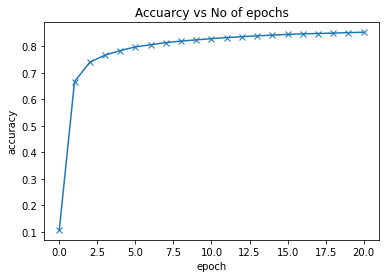

In [84]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuarcy vs No of epochs');


## Testing on Individual Images

In [87]:
from torchvision import transforms

In [88]:
test_dataset = MNIST(root='data/',
                     train = False,
                     transform = transforms.ToTensor())

shape torch.Size([1, 28, 28])
label 7


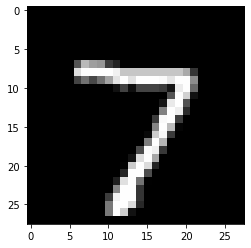

In [91]:
# sample image from the dataset

img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('shape', img.shape)
print('label',label)

In [92]:
# predict_image function to predict single label 

def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

`img.unsqueeze` simply adds another dimension at the begining of the 1x28x28 tensor, making it a 1x1x28x28 tensor, which the model views as a batch containing a single image.

label: 7 , predicted: 7


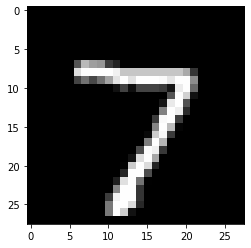

In [93]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('label:',label, ', predicted:',predict_image(img, model))

label: 2 , predicted: 2


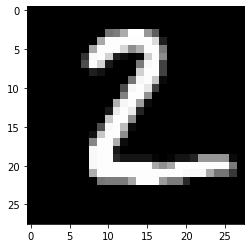

In [94]:
img, label = test_dataset[1]
plt.imshow(img[0], cmap='gray')
print('label:',label, ', predicted:',predict_image(img, model))

label: 1 , predicted: 1


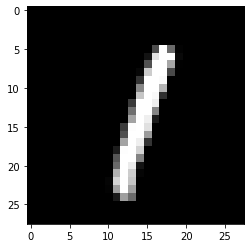

In [95]:
img, label = test_dataset[5]
plt.imshow(img[0], cmap='gray')
print('label:',label, ', predicted:',predict_image(img, model))

label: 9 , predicted: 9


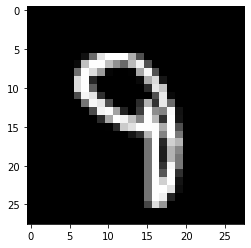

In [96]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('label:',label, ', predicted:',predict_image(img, model))

label: 2 , predicted: 8


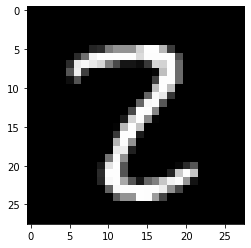

In [97]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('label:',label, ', predicted:',predict_image(img, model))         # Here Model in Breaking Up

In [98]:
# overall loss and accuracy of model on test set

test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6401068568229675, 'val_acc': 0.8603515625}

# Saving and Loading the Model

In [99]:
torch.save(model.state_dict(), 'mnist-logistic.pth') # .state_dict returns Ordered Dict containig all the weights and bias matrices mapped to right attributes of the model

In [100]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0064, -0.0261,  0.0092,  ...,  0.0320,  0.0143,  0.0129],
                      [-0.0179,  0.0100,  0.0158,  ...,  0.0125, -0.0167,  0.0209],
                      [ 0.0081,  0.0290, -0.0355,  ...,  0.0334, -0.0284, -0.0074],
                      ...,
                      [-0.0097, -0.0077,  0.0133,  ...,  0.0153, -0.0036,  0.0283],
                      [ 0.0289, -0.0290, -0.0317,  ..., -0.0190,  0.0308, -0.0353],
                      [-0.0043,  0.0184, -0.0096,  ...,  0.0319, -0.0038, -0.0067]])),
             ('linear.bias',
              tensor([-0.0544,  0.1269,  0.0047, -0.0240,  0.0016,  0.0284, -0.0175,  0.0452,
                      -0.0609, -0.0155]))])

In [101]:
# To load the model weights

model_2 = MnistModel()
model_2.load_state_dict(torch.load('mnist-logistic.pth'))
model_2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0064, -0.0261,  0.0092,  ...,  0.0320,  0.0143,  0.0129],
                      [-0.0179,  0.0100,  0.0158,  ...,  0.0125, -0.0167,  0.0209],
                      [ 0.0081,  0.0290, -0.0355,  ...,  0.0334, -0.0284, -0.0074],
                      ...,
                      [-0.0097, -0.0077,  0.0133,  ...,  0.0153, -0.0036,  0.0283],
                      [ 0.0289, -0.0290, -0.0317,  ..., -0.0190,  0.0308, -0.0353],
                      [-0.0043,  0.0184, -0.0096,  ...,  0.0319, -0.0038, -0.0067]])),
             ('linear.bias',
              tensor([-0.0544,  0.1269,  0.0047, -0.0240,  0.0016,  0.0284, -0.0175,  0.0452,
                      -0.0609, -0.0155]))])